In [1]:
!pip install transformers datasets -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==

In [2]:
!pip install evaluate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.2 MB/s eta 0:00:00


In [3]:
!pip install --upgrade transformers -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 116.2 MB/s eta 0:00:00


In [4]:
import json
import pandas as pd
from datasets import Dataset, DatasetDict

with open("qa.json") as f:
    data = json.load(f)

df = pd.DataFrame(data)

# Split 80-20
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

# Convert to HF dataset
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df.reset_index(drop=True))
})


In [5]:
len(train_df)

235

In [6]:
from transformers import AutoTokenizer

model_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess(example):
    input_text = f"question: {example['question']} context: {example['context']}"
    target_text = example["answer"]

    model_inputs = tokenizer(input_text, max_length=512, padding="max_length", truncation=True)
    labels = tokenizer(target_text, max_length=64, padding="max_length", truncation=True)
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs

tokenized_dataset = dataset.map(preprocess)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/235 [00:00<?, ? examples/s]

Map:   0%|          | 0/59 [00:00<?, ? examples/s]

In [7]:
from transformers import AutoModelForSeq2SeqLM, TrainingArguments, Trainer, TrainerCallback

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Custom callback to store loss
train_loss = []

class LossLogger(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs:
            train_loss.append(logs["loss"])

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=4,
    num_train_epochs=5,
    logging_steps=1,
    logging_dir="./logs",
    save_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    callbacks=[LossLogger]
)


<ipython-input-7-8b327b8311b5>:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [8]:
# 🧠 Load model
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


In [9]:
# 📊 Setup metrics
import evaluate

f1_metric = evaluate.load("f1")
em_metric = evaluate.load("exact_match")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Convert predictions and labels from tensor to lists
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Remove any padding tokens
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]

    # Compute F1 and Exact Match
    f1 = f1_metric.compute(predictions=decoded_preds, references=decoded_labels)
    em = em_metric.compute(predictions=decoded_preds, references=decoded_labels)

    return {
        "f1": f1["f1"],
        "exact_match": em["exact_match"]
    }


In [10]:
# 📉 Track training loss
from transformers import TrainingArguments, Trainer, TrainerCallback

train_loss = []

class LossLogger(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs:
            train_loss.append(logs["loss"])


In [11]:
# 🛠️ Training setup
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,  # Keep small to avoid OOM
    num_train_epochs=5,                      # Use half precision for lower memory
    logging_steps=1,
    eval_steps=30,   # Evaluate after each epoch 235/8
    save_strategy="epoch",
    logging_dir="./logs"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[LossLogger]
)


<ipython-input-11-03d3620b8ae8>:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [12]:
# 🚀 Train
import torch, os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.cuda.empty_cache()

trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shreysinha2002 (shreysinha2002-indian-institute-of-technology-patna) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
1,38.865800
2,32.135600
3,30.555200
4,28.740000
5,32.525800
6,25.403200
7,27.470500
8,21.132200
9,16.793100
10,27.995500


TrainOutput(global_step=150, training_loss=6.3324066336949665, metrics={'train_runtime': 345.5981, 'train_samples_per_second': 3.4, 'train_steps_per_second': 0.434, 'total_flos': 804589889126400.0, 'train_loss': 6.3324066336949665, 'epoch': 5.0})

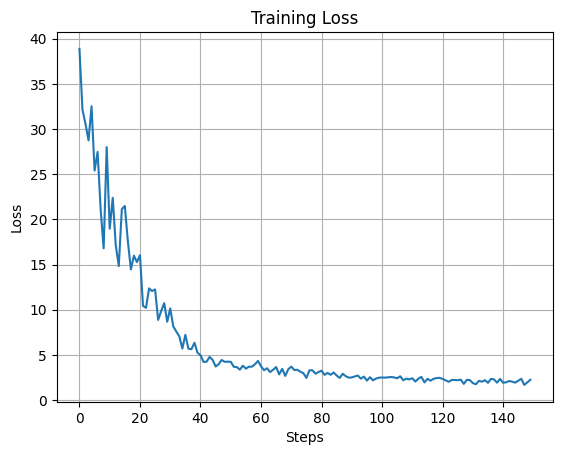

In [13]:
# 📈 Plot training loss
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.title("Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [14]:
# Save the model and tokenizer
model_save_path = "./finetuned_model"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

('./finetuned_model/tokenizer_config.json',
 './finetuned_model/special_tokens_map.json',
 './finetuned_model/spiece.model',
 './finetuned_model/added_tokens.json',
 './finetuned_model/tokenizer.json')

In [20]:
from google.colab import files
import os

# Zip everything inside /content
!zip -r finetuned_model.zip /content/finetuned_model



  adding: content/finetuned_model/ (stored 0%)
  adding: content/finetuned_model/model.safetensors (deflated 7%)
  adding: content/finetuned_model/tokenizer_config.json (deflated 95%)
  adding: content/finetuned_model/generation_config.json (deflated 29%)
  adding: content/finetuned_model/special_tokens_map.json (deflated 85%)
  adding: content/finetuned_model/tokenizer.json (deflated 74%)
  adding: content/finetuned_model/spiece.model (deflated 48%)
  adding: content/finetuned_model/config.json (deflated 62%)


In [21]:
!zip -r logs.zip /content/logs

  adding: content/logs/ (stored 0%)
  adding: content/logs/events.out.tfevents.1744969436.5f30fd111eb4.490.0 (deflated 69%)


In [1]:
import torch
import gc

# Clear cache and run garbage collection
torch.cuda.empty_cache()
gc.collect()


30

In [9]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_path = "./finetuned_model"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

In [8]:
from tqdm import tqdm

def generate_predictions(model, tokenizer, dataset, max_input_length=512, max_target_length=64):
    model.eval()
    predictions, references = [], []

    for item in tqdm(dataset):
        input_text = "question: " + item["question"] + " context: " + item["context"]
        input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True, max_length=max_input_length).to(model.device)

        with torch.no_grad():
            outputs = model.generate(input_ids, max_length=max_target_length)

        pred = tokenizer.decode(outputs[0], skip_special_tokens=True)
        predictions.append(pred.strip())
        references.append(item["answer"].strip())

    return predictions, references

# Generate predictions and references
predictions, references = generate_predictions(model, tokenizer, tokenized_dataset["test"])


100%|██████████| 59/59 [00:13<00:00,  4.38it/s]


In [14]:
from evaluate import load

# Load the SQuAD metric
squad_metric = load("squad")

# Generate predictions and references (this assumes they are already computed)
predictions, references = generate_predictions(model, tokenizer, tokenized_dataset["test"])



100%|██████████| 59/59 [00:34<00:00,  1.72it/s]


In [18]:
test_df

,context,question,answer
1,World War II or the Second World War (1 Septem...,What was the estimated number of deaths caused...,"Between 70 to 85 million people, over half of ..."
3,The causes of World War II included unresolved...,What territorial actions did Germany take befo...,Germany annexed Austria and the Sudetenland.
7,"In 1940, the Soviets annexed the Baltic states...",Which countries were part of the Axis alliance?,"Germany, Italy, Japan, and other allied nations."
13,"In 1944, the Western Allies invaded France at ...",Why did Japan surrender in August 1945?,"Because of the atomic bombings, the Soviet inv..."
20,Aircraft carriers became the dominant capital ...,Why did aircraft carriers become more importan...,Aircraft carriers became more important becaus...
21,"Submarines played a key role, with Germany imp...",How did Germany and Britain differ in their us...,Germany focused on improving offensive capabil...
34,"Despite pacifist sentiment after World War I, ...",What political sentiments emerged in Europe af...,Irredentist and revanchist nationalism.
48,The Arab–Israeli conflict escalated following ...,What triggered the escalation of the Arab–Isra...,The Arab rejection of the UN Partition Plan fo...
49,Decolonisation followed WWII as European power...,Why did decolonisation occur after World War II?,Because European powers lost prestige and reso...
50,The United States emerged as the richest count...,Which country became the world’s economic lead...,The United States.


In [15]:
predictions

['70 to 85 million deaths, more than half of which were civilians.',
 "Germany's invasion of Manchuria in 1931, the Spanish Civil War, the outbreak of the Second Sino-Japanese War in 1937, and Germany's annexations of Austria and the Sudetenland.",
 'Germany gained control of much of continental Europe and formed the Axis alliance with Italy, Japan, and other countries.',
 'Japan announced its unconditional surrender on 15 August.',
 'Battleships',
 'Submarines played a key role, with Germany improving offensive capabilities through Type VII submarines and wolfpack tactics, while the British focused on anti-submarine weapons like sonar and homing torpedoes.',
 'Rearrangement of the Union',
 'Following the Arab rejection of the UN Partition Plan and the creation of Israel, the Arab–Israeli conflict escalated following the Arab rejection of the UN Partition Plan and the creation of Israel.',
 'Decolonisation followed WWII as European powers could not maintain their empires.',
 'United St

In [16]:
references

['Between 70 to 85 million people, over half of whom were civilians.',
 'Germany annexed Austria and the Sudetenland.',
 'Germany, Italy, Japan, and other allied nations.',
 'Because of the atomic bombings, the Soviet invasion of Manchuria, and the threat of Allied invasion.',
 'Aircraft carriers became more important because they were crucial in naval battles and more economical than heavily armoured battleships.',
 'Germany focused on improving offensive capabilities, while Britain concentrated on anti-submarine weapons and tactics.',
 'Irredentist and revanchist nationalism.',
 'The Arab rejection of the UN Partition Plan for Palestine and the creation of Israel.',
 'Because European powers lost prestige and resources and could not maintain their empires.',
 'The United States.',
 'It helped Western European recovery and contributed to the German economic miracle.',
 'By seizing German industrial plants and exacting war reparations from satellite states.',
 'China returned to pre-wa

In [20]:
!pip install evaluate
import evaluate

bleu = evaluate.load("bleu")
results_bleu = bleu.compute(predictions=predictions, references=references)
print("BLEU:", results_bleu["bleu"])


BLEU: 0.21002019875153016


In [26]:
from evaluate import load

squad_v2_metric = load("squad_v2")

# Build data
predictions_formatted = [
    {
        "id": str(i),
        "prediction_text": pred,
        "no_answer_probability": 0.0
    } for i, pred in enumerate(predictions)
]

references_formatted = [
    {
        "id": str(i),
        "answers": {
            "text": [ref],
            "answer_start": [0]  # Safe default for evaluation
        }
    } for i, ref in enumerate(references)
]

# Compute
results = squad_v2_metric.compute(predictions=predictions_formatted, references=references_formatted)

# Print
print("✅ Evaluation Results:")
print(f"Exact Match: {results['exact']:.2f}")
print(f"F1 Score: {results['f1']:.2f}")


✅ Evaluation Results:
Exact Match: 6.78
F1 Score: 42.09
